# Практическая работа 3. Метод окна Парзена-Розенблатта

## Импорты

In [37]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

## Датасет с цифрами 8x8px из sklearn.
### Описание:
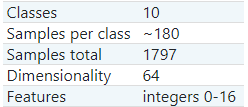


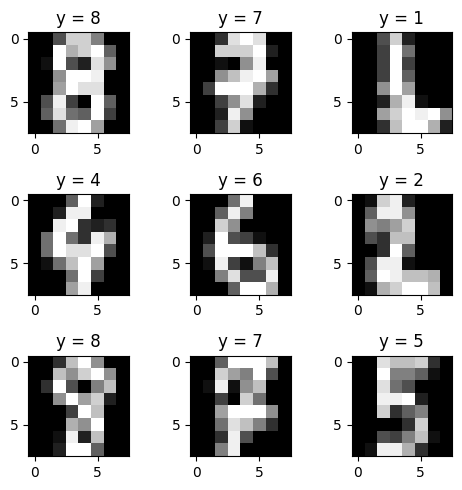

In [38]:
# Загружаем датасет
digits = load_digits()
x = digits.data
y = digits.target

# Разбиваем датасет на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)

images = X_train[:9]
labels = y_train[:9]

plt.gray()
gs = gridspec.GridSpec(3,3)

for i in range(9):
    ax = plt.subplot(gs[i])
    ax.set_title(f'y = {labels[i]}')
    ax.figure.set_size_inches((5,5))
    ax.imshow(images[i].reshape((8, 8)))

plt.tight_layout()
plt.show()


# Датасет с пингвинами
## Предобработка

In [39]:
penguins = sns.load_dataset("penguins")
penguins.dropna(inplace = True)
penguins.drop(['island', 'sex'], axis=1, inplace = True)
penguins_X = penguins.iloc[:, 1:]
penguins_Y = penguins.iloc[:, 0]

le = LabelEncoder()
penguins_Y = le.fit_transform(penguins_Y)

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(penguins_X, penguins_Y, test_size=.3, random_state=42)
X_train_p, X_test_p = X_train_p.to_numpy(), X_test_p.to_numpy()

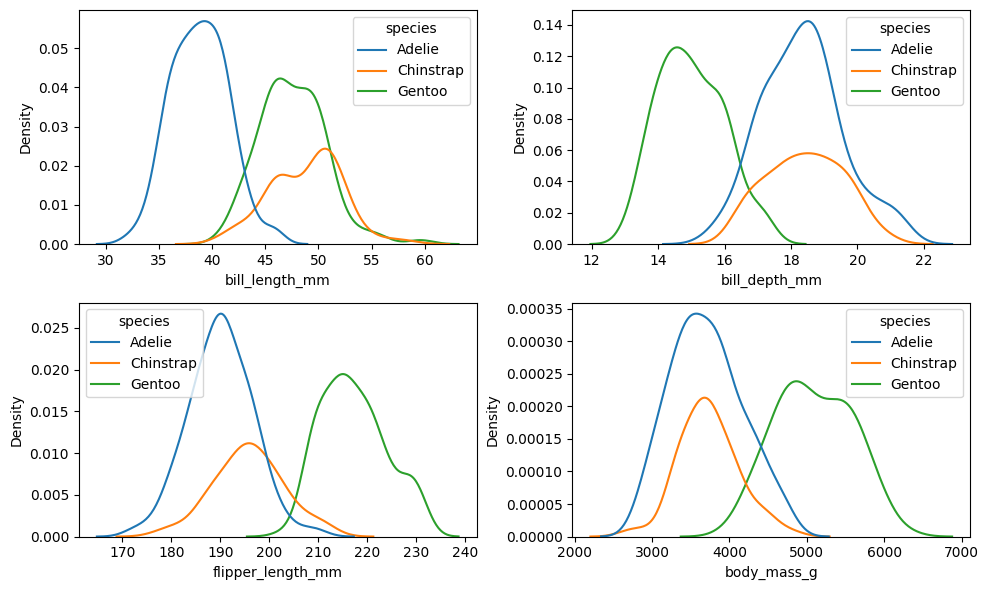

In [48]:
_, ax = plt.subplots(2, 2, figsize=(10, 6))
for col, ax in zip(penguins_X.columns, ax.flatten()):
    sns.kdeplot(data=penguins, x = col, hue = 'species', ax = ax)
plt.tight_layout()

# Реализация непараметрической модели
* ### Ядерный оценщик плотности: ![image](image.jpg)
* ### В качестве ядра K была выбрана Гауссова функция, так как она является наиболее часто используемой. Так же она имеет бесконечную дифференцируемость и нормальное распределение.

In [41]:
# Определяем ядерную функцию (Гауссова)
def kernel(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)

In [42]:
# Создаем класс ParzenRosenblatt
class ParzenRosenblatt:
    def __init__(self, kernel, h = 1):
        self.kernel = kernel
        self.h = h
        self.results = None
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.prior = np.bincount(y) / len(y)
    
    def predict(self, x):
        proba = self.posterior(x)
        return np.argmax(proba, axis=0)
    
    # Находим лучший параметр сглаживания h
    def find_best_h(self, h_array, x, y):
        best_h = h_array[0]
        best_acc = 0
        
        for i in h_array: 
            
            self.h = i
            proba = self.posterior(x)
            y_pred = np.argmax(proba, axis = 0)
            acc = accuracy_score(y, y_pred)
            
            if (acc > best_acc):
                best_h = i
                best_acc = acc

        self.h = best_h
        
        return self.h

    # Вычисляет апостериорные вероятности классов
    def posterior(self, x):
        # Вычисляем оценки плотности вероятности для каждого класса
        densities = np.array([self.density(x, self.X[self.y == c]) for c in range(len(self.prior))])
        # Вычисляем апостериорные вероятности классов
        return densities * self.prior.reshape(-1, 1) / np.sum(densities * self.prior.reshape(-1, 1) + 1e-6, axis=0)
    
    # Вычисляем оценку плотности вероятности для матрицы x
    def density(self, x, X):
        # Вычисляем матрицу расстояний между каждой строкой x и каждой строкой X
        dist = np.linalg.norm(x[:, np.newaxis, :] - X, axis=2)
        # Применяем ядерную функцию к матрице расстояний
        return np.sum(self.kernel(dist / self.h), axis=1) / (len(X) * self.h)
    

# Результаты для цифр

In [43]:
model = ParzenRosenblatt(kernel = kernel)
model.fit(X_train, y_train)
print("Best h is: ", model.find_best_h(np.arange(0.1, 5.1, 0.1), X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Best h is:  4.8
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.98      1.00      0.99        50
           2       1.00      1.00      1.00        47
           3       0.98      1.00      0.99        54
           4       0.98      1.00      0.99        60
           5       1.00      0.98      0.99        66
           6       1.00      1.00      1.00        53
           7       1.00      0.98      0.99        55
           8       1.00      0.98      0.99        43
           9       0.97      0.97      0.97        59

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540



# Результаты для пингвинов

In [44]:
model = ParzenRosenblatt(kernel = kernel)
model.fit(X_train_p, y_train_p)
print("Best h is: ", model.find_best_h(np.arange(0.1, 5.1, 0.1), X_test_p, y_test_p))
print(le.classes_)
y_pred = model.predict(X_test_p)
print(classification_report(y_test_p, y_pred))

Best h is:  3.8000000000000003
['Adelie' 'Chinstrap' 'Gentoo']
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        48
           1       0.58      0.61      0.59        18
           2       0.94      0.97      0.96        34

    accuracy                           0.84       100
   macro avg       0.80      0.81      0.80       100
weighted avg       0.84      0.84      0.84       100

